epoch: 0, loss: 0.7085004451136929
epoch: 500, loss: 0.1718002251291139
epoch: 1000, loss: 0.0008190258158097125
epoch: 1500, loss: 1.843799491418885e-07
epoch: 2000, loss: 1.074057509597992e-12
tensor([ 7.0711e-01-1.6653e-16j,  0.0000e+00-0.0000e+00j,
         0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
         0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
         0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
         5.0262e-07-2.2986e-07j,  0.0000e+00-0.0000e+00j,
         0.0000e+00-0.0000e+00j,  0.0000e+00-0.0000e+00j,
        -2.5938e-07-4.8804e-07j,  0.0000e+00-0.0000e+00j,
        -4.7173e-07+2.8798e-07j,  7.0711e-01-3.1275e-13j],
       dtype=torch.complex128, grad_fn=<MulBackward0>)


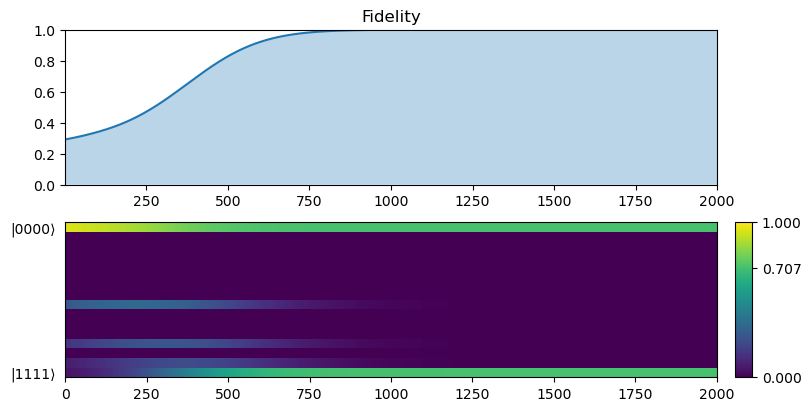

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import Dataset
from torch.nn.parameter import Parameter
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

n_test_qubits = 16 

n_ghz = 4

batch_size = 16

num_epochs = 2001

learning_rate = 1e-3

loss_graph = []

q0_graph = []
q1_graph = []
q2_graph = []
q3_graph = []
q4_graph = []
q5_graph = []
q6_graph = []
q7_graph = []
q8_graph = []
q9_graph = []
q10_graph = []
q11_graph = []
q12_graph = []
q13_graph = []
q14_graph = []
q15_graph = []

c_not = torch.tensor([[1,0,0,0],
                      [0,1,0,0],
                      [0,0,0,1],
                      [0,0,1,0]], dtype=torch.complex128)

i = torch.tensor([[1,0],
                  [0,1]], dtype=torch.complex128)
h = torch.tensor([[1,1],
                  [1,-1]] / np.sqrt(2), dtype=torch.complex128)

#===============================================================================================================================
#Create the data set

class input_vec_dataset(Dataset):
    def __init__(self):
        
        dataset = []
        labels = []
        
        for a in range(n_test_qubits):
            phi = np.random.rand() * 2*np.pi
            theta = np.random.rand() * np.pi
    
            input_qubit = torch.tensor([np.sin(theta), np.cos(theta) * np.exp(1j * phi)])
            out = h @ input_qubit
            
            c_not1 = c_not
            q0 = torch.tensor([1,0],dtype=torch.complex128)
            
            for n in range(n_ghz-1):
                out = torch.kron(out,q0)
                out = out @ c_not1
                c_not1 = torch.kron(i,c_not1)
            
            dataset.append(input_qubit)
            labels.append(out)
            
        self.dataset = torch.stack(dataset)
        self.labels = torch.stack(labels)
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, idx):
        return self.dataset[idx],self.labels[idx]
    
#===============================================================================================================================
#Load the data set

data_set = input_vec_dataset()

data_loader = torch.utils.data.DataLoader(data_set, batch_size=batch_size, shuffle=False, drop_last=False)

#===============================================================================================================================

def elements_to_matrix(matrix_entries: list):
    return torch.stack([torch.stack([value for value in row]) for row in matrix_entries]).squeeze()

#===============================================================================================================================
#The model

class HModel(torch.nn.Module):
    
    def __init__(self):
        super(HModel, self).__init__()
        self.θ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.θ1 = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.α1 = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.β1 = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
        self.ϕ1 = Parameter(2 * np.pi * torch.rand(1, dtype=torch.float64))
      
    def forward(self, x):
        θ = self.θ
        α = self.α
        β = self.β
        ϕ = self.ϕ
        θ1 = self.θ1
        α1 = self.α1
        β1 = self.β1
        ϕ1 = self.ϕ1
        q0 = torch.tensor([1,0], dtype=torch.complex128, requires_grad=False)
 
        U = elements_to_matrix(
            [[torch.exp(1j * α) * torch.cos(θ), torch.exp(1j * β) * torch.sin(θ)],
             [- torch.exp(-1j * β) * torch.sin(θ), torch.exp(-1j * α) * torch.cos(θ)]])
    
        t0 = torch.tensor([0],dtype=torch.complex128)
        t1 = torch.tensor([1],dtype=torch.complex128)
        
        C = elements_to_matrix(
            [[t1,t0,t0,t0],
             [t0,t1,t0,t0],
             [t0,t0,torch.exp(1j * α1) * torch.cos(θ1), torch.exp(1j * β1) * torch.sin(θ1)],
             [t0,t0,- torch.exp(-1j * β1) * torch.sin(θ1), torch.exp(-1j * α1) * torch.cos(θ1)]])

        if len(x.shape) == 1:
            out = U @ x
            c_not4 = C
            for n in range(n_ghz-1):
                out = torch.kron(out,q0)
                out = out @ c_not4
                c_not4 = torch.kron(i,c_not4)
            return out
        else:
            c_not2 = C
            out = U @ q0

            for n in range(n_ghz-1):
                out = torch.kron(out,q0)
                out = out @ c_not2
                c_not2 = torch.kron(i,c_not2)

            q0_graph.append(abs(out[0].tolist()))
            q1_graph.append(abs(out[1].tolist()))
            q2_graph.append(abs(out[2].tolist()))
            q3_graph.append(abs(out[3].tolist()))
            q4_graph.append(abs(out[4].tolist()))
            q5_graph.append(abs(out[5].tolist()))
            q6_graph.append(abs(out[6].tolist()))
            q7_graph.append(abs(out[7].tolist()))
            q8_graph.append(abs(out[8].tolist()))
            q9_graph.append(abs(out[9].tolist()))
            q10_graph.append(abs(out[10].tolist()))
            q11_graph.append(abs(out[11].tolist()))
            q12_graph.append(abs(out[12].tolist()))
            q13_graph.append(abs(out[13].tolist()))
            q14_graph.append(abs(out[14].tolist()))
            q15_graph.append(abs(out[15].tolist()))
            
            x_out = []
            
            for a in batch:

                x = U @ a
                c_not3 = C
                for n in range(n_ghz-1):
                    x = torch.kron(x,q0)
                    x = x @ c_not3
                    c_not3 = torch.kron(i,c_not3)
                x_out.append(x)
                
            return torch.stack(x_out)      

#===============================================================================================================================
#Loss function

def quantum_infidelity_batched(state_batch, target_state_batch):

    loss = torch.stack([torch.abs((1 - torch.abs(torch.dot(target_state.conj(), state))**2))
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    fidelity = torch.stack([torch.abs(torch.dot(target_state.conj(), state))**2
                        for state, target_state in zip(state_batch, target_state_batch)]).mean()
    
    loss_graph.append(fidelity.item())
    
    return loss

#===============================================================================================================================
#Train the model

model = HModel()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    
    for batch, labels in data_loader:
        
        optimizer.zero_grad()
        
        outputs = model(batch)
        
        loss = quantum_infidelity_batched(outputs, labels) 

        loss.backward()
        
        optimizer.step()
        
    if epoch % 500 == 0:
        
        print(f'epoch: {epoch}, loss: {loss}')
        
#===============================================================================================================================
#Test the model

model.eval()

q0 = model(torch.tensor([1,0],dtype=torch.complex128, requires_grad=False))
fake_global_phase = torch.angle(q0[0])
q0 = torch.exp(-1j * fake_global_phase) * q0
print(q0)

#===============================================================================================================================
#Graph the progress of the model

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,4), height_ratios=(1,1), layout='constrained')

x_graph = np.arange(num_epochs * n_test_qubits / batch_size)
y_graph = np.zeros(int(num_epochs * n_test_qubits / batch_size))

q_graph = np.array([q15_graph,q14_graph,q13_graph,q12_graph,
                    q11_graph,q10_graph,q9_graph,q8_graph,
                    q7_graph,q6_graph,q5_graph,q4_graph,
                    q3_graph,q2_graph,q1_graph,q0_graph])

norm = mpl.colors.Normalize(vmin=0, vmax=1)

cs = ax2.pcolormesh(q_graph, norm=norm, cmap='viridis')

cbar = fig.colorbar(cs, ax=ax2, pad=0, aspect=9)
cbar.set_ticks([0, 1/np.sqrt(2), 1])

ax2.set_yticks([0.5,15.5], labels=['|1111⟩','|0000⟩'])
ax2.tick_params(left = False)

ax1.set_title('Fidelity')
ax1.set_ylim(0,1)
ax1.set_xlim(1,num_epochs * n_test_qubits / batch_size-1)
ax1.plot(x_graph,loss_graph)
ax1.fill_between(x_graph, loss_graph, alpha=0.3)

#===============================================================================================================================
#Suppress console output

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout